# Charite cyTOF data 

Here we re-analyse cyTOF data of T cells from COVID-19 patients. In this notebook, we preprocess COVID-19 cyTOF data, which have been collected in the [Georg et al. study](https://www.sciencedirect.com/science/article/pii/S0092867421015622?via%3Dihub). The PBMC, serum and wholeblood data were sampled several COVID-19 patients and the study examined the cytotoxic potential of activated T-cells in patients with COVID-19.  


## Download data

In [1]:
# !wget https://zenodo.org/record/5771937/files/data_norm_all.csv.gz?download=1 -o ../data/geog_data_norm_all.log

In [2]:
!wget https://zenodo.org/record/5771937/files/data_Tcells_annotated.csv.gz 

--2023-03-07 01:14:10--  https://zenodo.org/record/5771937/files/data_Tcells_annotated.csv.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420415607 (401M) [application/octet-stream]
Saving to: ‘data_Tcells_annotated.csv.gz’

data_Tcells_annotat 100%[===================>] 400.94M  99.5MB/s    in 4.3s    

2023-03-07 01:14:23 (93.5 MB/s) - ‘data_Tcells_annotated.csv.gz’ saved [420415607/420415607]



Unzip data.

In [ ]:
#!gzip -d data_norm_all.csv.gz

tar: This does not look like a tar archive
tar: Skipping to next header


In [5]:
!gzip -d data_Tcells_annotated.csv.gz

## Load packages 

In [6]:
import scanpy as sc
import anndata as ann
import numpy as np
import pandas as pd

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime

In [8]:
import os
import re

In [9]:
sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cloudpickle         2.0.0
colorama            0.4.5
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.01.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
fsspec              2022.7.1
google              NA
h5py                3.1.0
ipykernel           6.15.1
ipython_genutils    0.2.0
ipywidgets          7.7.1
jedi                0.18.1
jinja2              3.1.2
joblib              1.1.0
jupyter_server      1.18.1
kiwisolver          1.4.4
llvmlite            0.38.1
markupsafe          2.1.1
matplotlib          3.5.3
mpl_toolkits        NA


Get date.

In [10]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

## Read data

In [11]:
#df = pd.read_csv('./data_norm_all.csv')

/home/buettnerm/miniconda3/envs/rapidgenomics/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (10,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df_anno = pd.read_csv('./data_Tcells_annotated.csv')

/home/buettnerm/miniconda3/envs/rapidgenomics/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (10,11,13,56,57,58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
#df.columns

Index(['cellid', 'Run', 'FCS.Filename', 'id', 'Individuals', 'Group',
       'Severity', 'Disease.phase', 'max. WHO scale', 'sev_merge',
       'Days.post.symptom.onset', 'Week', 'sev_week', 'followup', 'CD45',
       'CD3', 'CD19', 'CD15', 'CD8', 'TCRgd', 'CD62L', 'CD45RO', 'CD28',
       'CD27', 'CD226', 'ICOS', 'PD1', 'Lag3', 'TIGIT', 'CD96', 'CD25', 'CD56',
       'HLADR', 'CD38', 'CD137', 'CD69', 'Ki67', 'CXCR3', 'CXCR5', 'CCR6',
       'CRTH2', 'KLRB1', 'KLRG1', 'KLRF1', 'CD95', 'CD10', 'CD16', 'CD34',
       'CD123', 'CD11c', 'CD21', 'CD14', 'IgD', 'IgM'],
      dtype='object')

In [14]:
#df.shape

(23247998, 54)

In [15]:
df_anno.shape

(1784732, 62)

In [18]:
df_anno.columns

Index(['cellid', 'Run', 'FCS.Filename', 'id', 'Individuals', 'Group',
       'Severity', 'Disease.phase', 'max. WHO scale', 'sev_merge',
       'Days.post.symptom.onset', 'Week', 'sev_week', 'followup', 'CD45',
       'CD3', 'CD19', 'CD15', 'CD8', 'TCRgd', 'CD62L', 'CD45RO', 'CD28',
       'CD27', 'CD226', 'ICOS', 'PD1', 'Lag3', 'TIGIT', 'CD96', 'CD25', 'CD56',
       'HLADR', 'CD38', 'CD137', 'CD69', 'Ki67', 'CXCR3', 'CXCR5', 'CCR6',
       'CRTH2', 'KLRB1', 'KLRG1', 'KLRF1', 'CD95', 'CD10', 'CD16', 'CD34',
       'CD123', 'CD11c', 'CD21', 'CD14', 'IgD', 'IgM', 'Tcellcompartment',
       'pheno_acute', 'metacluster_num', 'metacluster_name', 'new_clust_name',
       'new_clust_num', 'UMAP1', 'UMAP2'],
      dtype='object')

In [17]:
df_anno.head()

,cellid,Run,FCS.Filename,id,Individuals,Group,Severity,Disease.phase,max. WHO scale,sev_merge,...,IgD,IgM,Tcellcompartment,pheno_acute,metacluster_num,metacluster_name,new_clust_name,new_clust_num,UMAP1,UMAP2
0,2,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,3.507821,15.367002,CD4+,NaN,NaN,NaN,NaN,NaN,1.483736,-0.659450
1,4,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.886470,12.608067,CD8+,NaN,NaN,NaN,NaN,NaN,2.333084,-6.212416
2,12,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.000000,1.854850,CD4+,NaN,NaN,NaN,NaN,NaN,-3.276101,-5.658602
3,14,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,1.357457,0.000000,CD4+,NaN,NaN,NaN,NaN,NaN,-2.068011,-5.061034
4,26,210130,210130_Blut_Panel1_CV19_BC_9_viable.fcs,"CV-284, week 6",CV-284,CV19,mild,convalescent,2.0,mild,...,0.000000,9.726293,CD4+,NaN,NaN,NaN,NaN,NaN,3.178484,-2.645567


In [20]:
df_anno[['Tcellcompartment', 'new_clust_name',
       'new_clust_num']].value_counts()

Tcellcompartment  new_clust_name                     new_clust_num
CD4+              CD38+                              C4               107566
                  CD226+CD25+                        C9                82698
                  CD25+                              C5                81464
CD8+              CD38+                              C24               81410
CD4+              CD226+CD25+CD11c+                  C16               72255
CD8+              PD1+TIGIT+CD137+                   C29               68770
                  CD25+                              C27               62627
CD4+              CD226+CD25+KLRB1+                  C10               55971
CD8+              CD226+LAG3+TIGIT+KLRG1+            C33               55777
CD4+              Treg-like                          C2                48773
                  CD226+CD25+CD11c+                  C11               48158
                  CD226+PD1+                         C15               48033
         

Convert annotated dataset into anndata object.

In [32]:
var_names = ['CD45',
       'CD3', 'CD19', 'CD15', 'CD8', 'TCRgd', 'CD62L', 'CD45RO', 'CD28',
       'CD27', 'CD226', 'ICOS', 'PD1', 'Lag3', 'TIGIT', 'CD96', 'CD25', 'CD56',
       'HLADR', 'CD38', 'CD137', 'CD69', 'Ki67', 'CXCR3', 'CXCR5', 'CCR6',
       'CRTH2', 'KLRB1', 'KLRG1', 'KLRF1', 'CD95', 'CD10', 'CD16', 'CD34',
       'CD123', 'CD11c', 'CD21', 'CD14', 'IgD', 'IgM']
adata_anno = ann.AnnData(X=df_anno[var_names], obs= df_anno[['cellid', 'Run', 'FCS.Filename', 'id', 'Individuals', 'Group',
       'Severity', 'Disease.phase', 'max. WHO scale', 'sev_merge',
       'Days.post.symptom.onset', 'Week', 'sev_week', 'followup', 'Tcellcompartment',
       'pheno_acute', 'metacluster_num', 'metacluster_name', 'new_clust_name',
       'new_clust_num']]) 

/tmp/ipykernel_4143046/3248659095.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_anno = ann.AnnData(X=df_anno[var_names], obs= df_anno[['cellid', 'Run', 'FCS.Filename', 'id', 'Individuals', 'Group',


In [29]:
adata_anno.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1784722', '1784723', '1784724', '1784725', '1784726', '1784727',
       '1784728', '1784729', '1784730', '1784731'],
      dtype='object', length=1784732)

In [34]:
df_umap = df_anno[['UMAP1', 'UMAP2']]
df_umap.index = adata_anno.obs_names

In [43]:
adata_anno.obsm['X_umap'] = df_umap.to_numpy()

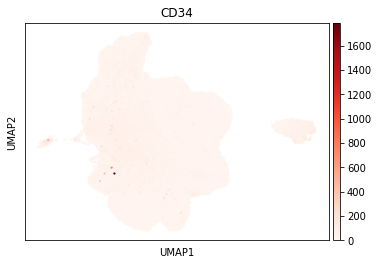

In [46]:
sc.pl.umap(adata_anno, color='CD34', size=20, cmap='Reds')

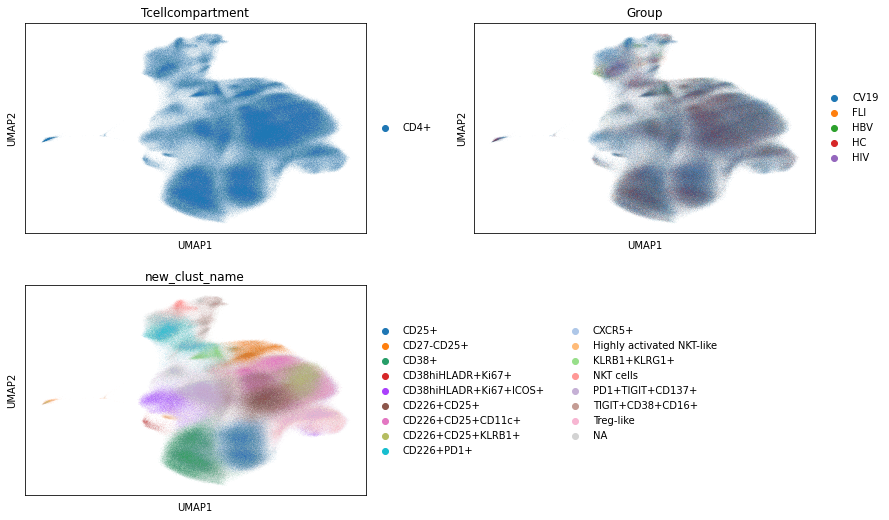

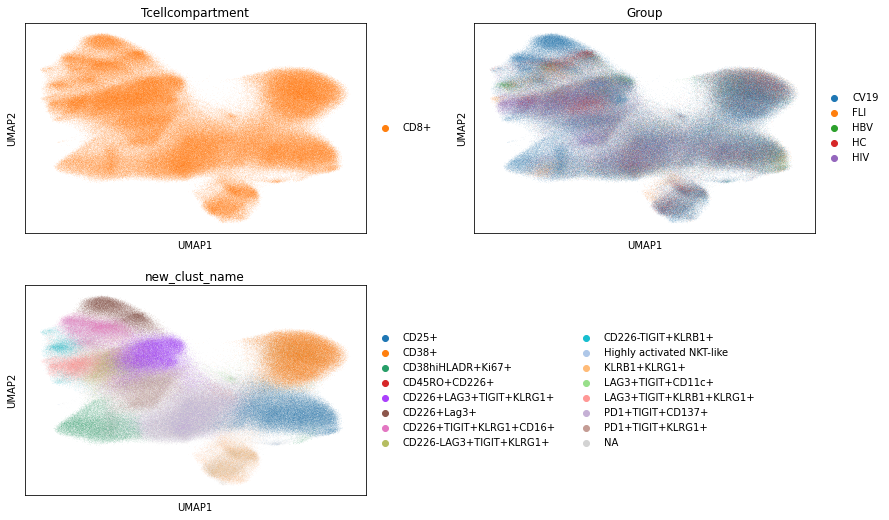

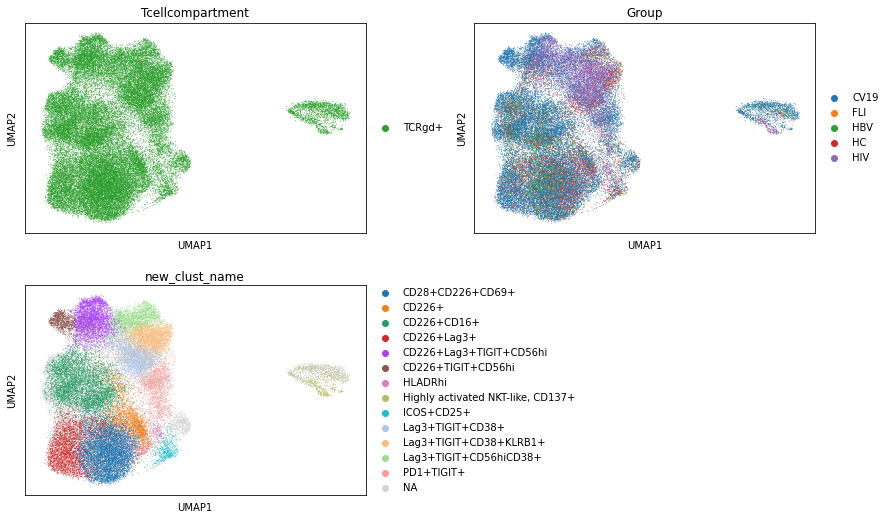

In [50]:
for comp in adata_anno.obs['Tcellcompartment'].cat.categories:
    adata_tmp= adata_anno[adata_anno.obs['Tcellcompartment']==comp].copy()
    sc.pl.umap(adata_tmp, color=['Tcellcompartment','Group', 'new_clust_name'],wspace =0.2, ncols=2)

## Convex gating tasks

We use the COVID-19 dataset as demonstration for convex gating. The original publication shows an increase of the following populations:

|T cell compartment |Cell type|
|-|-|
|CD4+ | cluster 7 (CD38hi HLA-DR+ Ki-67+ ICOS+) |
| | cluster 8 (highly activated NKT-like) |
|CD8+ | cluster 25 (CD38hi HLA-DR+ Ki-67+)|
| | cluster 26 (highly activated NKT-like) |

Signature of highly activated NKT-like cells: CD3+ CD16+ HLA-DR+ (in both CD4+ and CD8+ T cell compartment) - both associated with severe COVID-19 outcome.

## Task (within dataset):
* subset to COVID-19 data, infer gating strategy for cluster 8 and cluster 26. Report F1-score, precision, and recall. Apply gates to all other Groups (to report the absence of those cells in other contexts). Check with authors and results from paper. 